In [15]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import math

In [13]:
hdulist = fits.open('../petroC_nsa_gzoo.fits')
tbdata = hdulist[1].data
color = tbdata['col10'] #^{0.1}(g-r), K-E corrected to z=0.1, petro
M_r = tbdata['col9'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, petro
pfeatures = tbdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
psmooth = tbdata['t01_smooth_or_features_a01_smooth_weighted_fraction']
sSFR = tbdata['B300']
hdulist.close()

In [16]:
early_pfeatures = []
early_psmooth = []
late_pfeatures = []
late_psmooth = []
for i in np.arange(pfeatures.size):
    color_line = 0.7 - 0.032*(M_r[i] + 16.5)
    active_line = -10 + 0.094*(M_r[i] + 15)
    logsSFR = math.log(sSFR[i], 10)
    if color[i] >= color_line: #red galaxies
        if logsSFR <= active_line: #passive galaxies
            early_pfeatures.append(pfeatures[i])
            early_psmooth.append(psmooth[i])
    elif logsSFR >= active_line: #blue and active
        late_pfeatures.append(pfeatures[i])
        late_psmooth.append(psmooth[i])

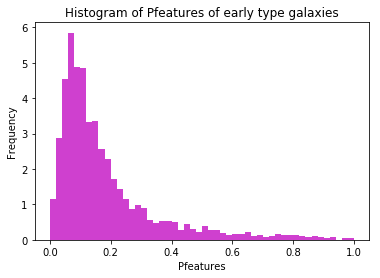

In [19]:
# the histogram of the data
n, bins, patches = plt.hist(early_pfeatures, 50, normed=1, facecolor='m', alpha=0.75)

#alpha is a parameter which sets the saturation of the colour
#normed normalises the area to 1. 

plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures of early type galaxies')
plt.show()

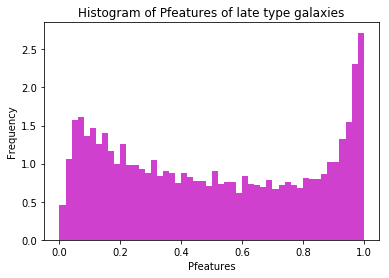

In [20]:
# the histogram of the data
n, bins, patches = plt.hist(late_pfeatures, 50, normed=1, facecolor='m', alpha=0.75)

#alpha is a parameter which sets the saturation of the colour
#normed normalises the area to 1. 

plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures of late type galaxies')
plt.show()

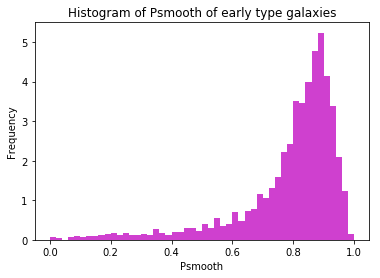

In [21]:
# the histogram of the data
n, bins, patches = plt.hist(early_psmooth, 50, normed=1, facecolor='m', alpha=0.75)

#alpha is a parameter which sets the saturation of the colour
#normed normalises the area to 1. 

plt.xlabel('Psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of Psmooth of early type galaxies')
plt.show()

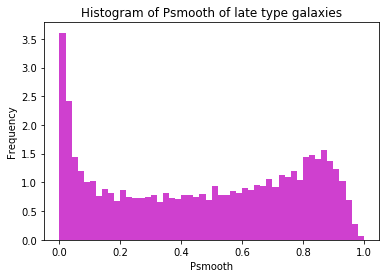

In [23]:
# the histogram of the data
n, bins, patches = plt.hist(late_psmooth, 50, normed=1, facecolor='m', alpha=0.75)

#alpha is a parameter which sets the saturation of the colour
#normed normalises the area to 1. 

plt.xlabel('Psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of Psmooth of late type galaxies')
plt.show()